Simple contrast model; should predict V1

In [1]:
import vm_tools as vmt #TEMP

import matplotlib.pyplot as plt
import numpy as np
import h5py
import sys
import os

from scipy.stats import zscore
import cortex as cx

sys.path.append(os.path.abspath('../'))
import utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
# Ridge regression function.
# Note that with a = 0, this is THE SAME as OLS regression!
def ridge(X, Y, a=0):
    b = np.linalg.inv(X.T.dot(X) + a * np.eye(X.shape[1])).dot(X.T.dot(Y))
    return b

In [2]:
with h5py.File('/unrshare/LESCROARTSHARE/IntroToEncodingModels/color_natims_images.hdf') as hf:
    im_est = hf['est'].value
    im_val = hf['val'].value

In [3]:
im_est.shape

(96, 96, 3, 1260)

In [4]:
16 * 16

256

Simple idea: compute image contrast over a 16 x 16 grid. This will yield 16 x 16 = 256 features. 

In [5]:
from skimage import color as skcol

In [6]:
# Convert images to grayscale
im_est_g = np.dstack([skcol.rgb2gray(im_est[...,i]) for i in range(1260)])
im_val_g = np.dstack([skcol.rgb2gray(im_val[...,i]) for i in range(126)])

In [7]:
print(im_est_g.shape)
print(im_val_g.shape)

(96, 96, 1260)
(96, 96, 126)


In [9]:
Xest = np.zeros((1260, 256))
Xval = np.zeros((126, 256))
tiles = np.arange(0, 97, 6)
i = 0
for xst, xfin in zip(tiles[:-1], tiles[1:]):
    for yst, yfin in zip(tiles[:-1], tiles[1:]):
        tmp = im_est_g[xst:xfin, yst:yfin]
        tmp_r = tmp.reshape(-1, 1260)
        Xest[:, i] = tmp_r.std(0)
        tmp = im_val_g[xst:xfin, yst:yfin]
        tmp_r = tmp.reshape(-1, 126)
        Xval[:, i] = tmp_r.std(0)
        i += 1
        
Xest = zscore(Xest, axis=0)
Xval = zscore(Xval, axis=0)

In [10]:
with h5py.File('/unrshare/LESCROARTSHARE/IntroToEncodingModels/s01_color_natims_data.hdf') as hf:
    Yest = hf['est'].value
    Yval = hf['val'].value
    mask = hf['mask'].value

In [43]:
B = utils.ols(Xest, Yest)

In [44]:
B.shape

(256, 65242)

In [47]:
out = vmt.Regression.ridge_cv(Xest, Yest, val_fs=Xval, val_data=Yval, 
                              chunk_sz=100000, is_verbose=True)

/home/mark/Code/vm_tools/vm_tools/Stats/utils.py:48: RuntimeWarning: Mean of empty slice
  zs = lambda x: (x-np.nanmean(x, axis=0))/np.nanstd(x, axis=0, ddof=dof)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/mark/Code/vm_tools/vm_tools/Stats/utils.py:54: RuntimeWarning: invalid value encountered in true_divide
  r = rTmp/n
/home/mark/Code/vm_tools/vm_tools/Stats/utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda x: (x-np.nanmean(x, axis=0))/np.nanstd(x, axis=0, ddof=dof)
/home/mark/Code/vm_tools/vm_tools/Regression/ridge.py:30: RuntimeWarning: Mean of empty slice
  trncc_byvox = np.nanmean(pred_by_alpha, axis=-1)
/home/mark/Code/vm_tools/vm_tools/Regression/ridge.py:204: UserWarning: First column of val_fs is NOT all ones! Consider including a DC term!
  warnings.warn('First column of val_fs is NOT all ones! Consider including a DC term!')


Computing SVD


In [48]:
yhat = Xval.dot(B)

In [49]:
r = utils.column_corr(yhat, Yval)

/home/mark/Code/UNR_PSY_763/utils/__init__.py:11: RuntimeWarning: Mean of empty slice
  zs = lambda x: (x-np.nanmean(x, axis=0))/np.nanstd(x, axis=0, ddof=dof)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/mark/Code/UNR_PSY_763/utils/__init__.py:17: RuntimeWarning: invalid value encountered in true_divide
  r = rTmp/n


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


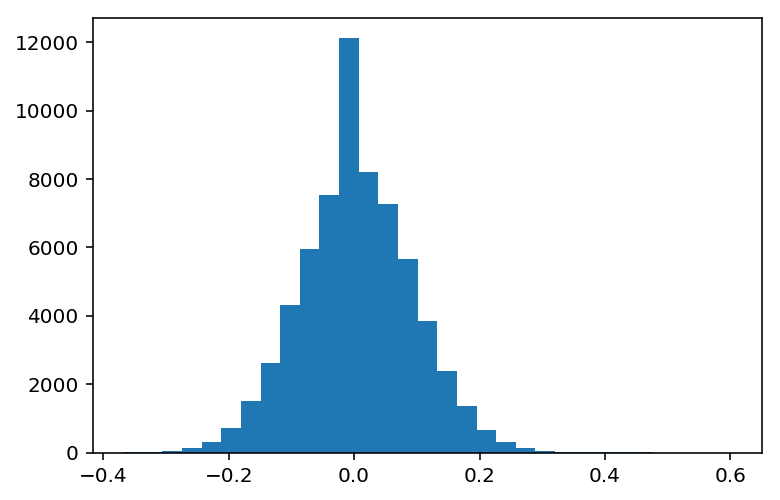

In [50]:
plt.hist(np.nan_to_num(r), bins=31);

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


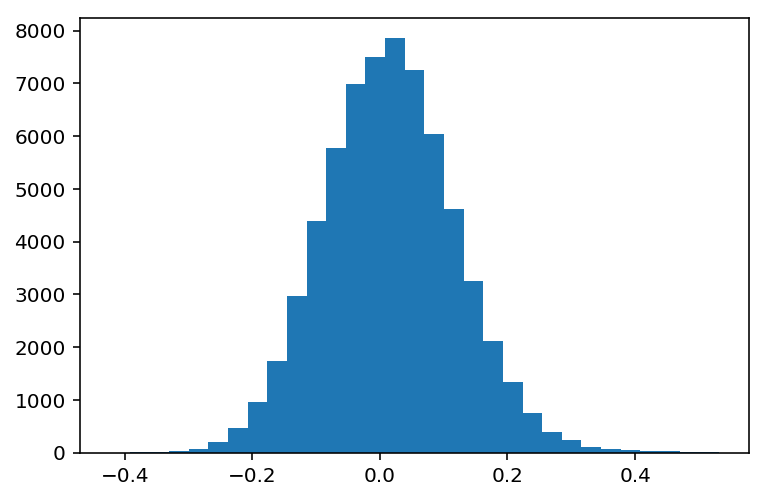

In [53]:
plt.hist(np.nan_to_num(out['cc']), bins=31);

In [51]:
sub, xfm = 's01', 'color_natims'
Vols = cx.Volume(r, sub, xfm, vmin=0, vmax=0.5, cmap='inferno', mask=mask)
Vridge = cx.Volume(out['cc'], sub, xfm, vmin=0, vmax=0.5, cmap='inferno', mask=mask)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


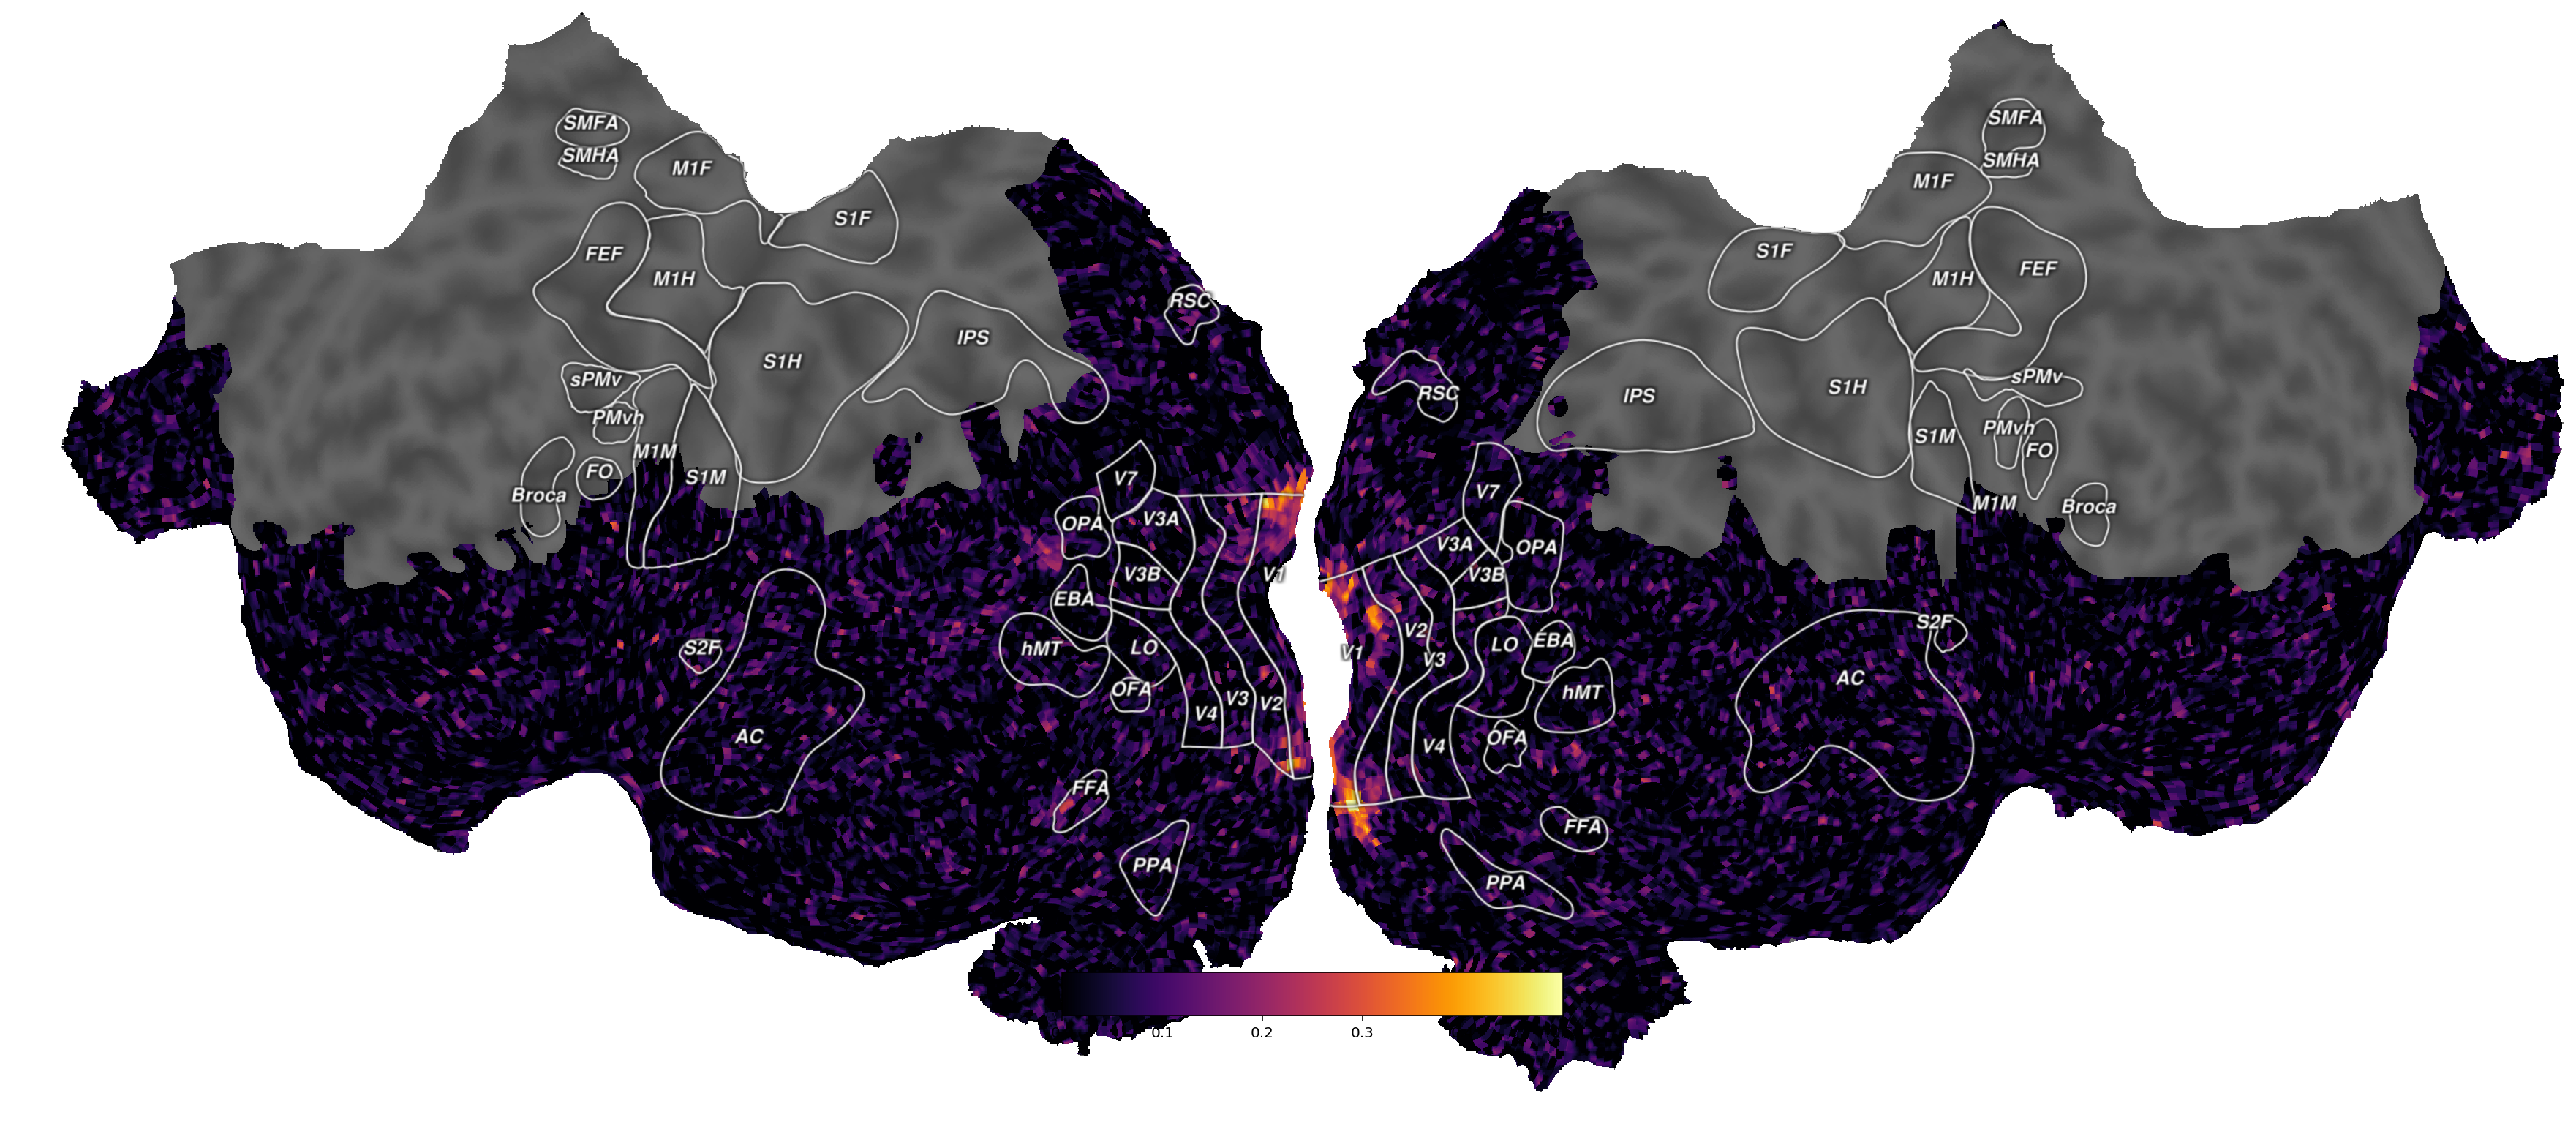

In [54]:
fig = cx.quickflat.make_figure(Vols, with_curvature=True)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


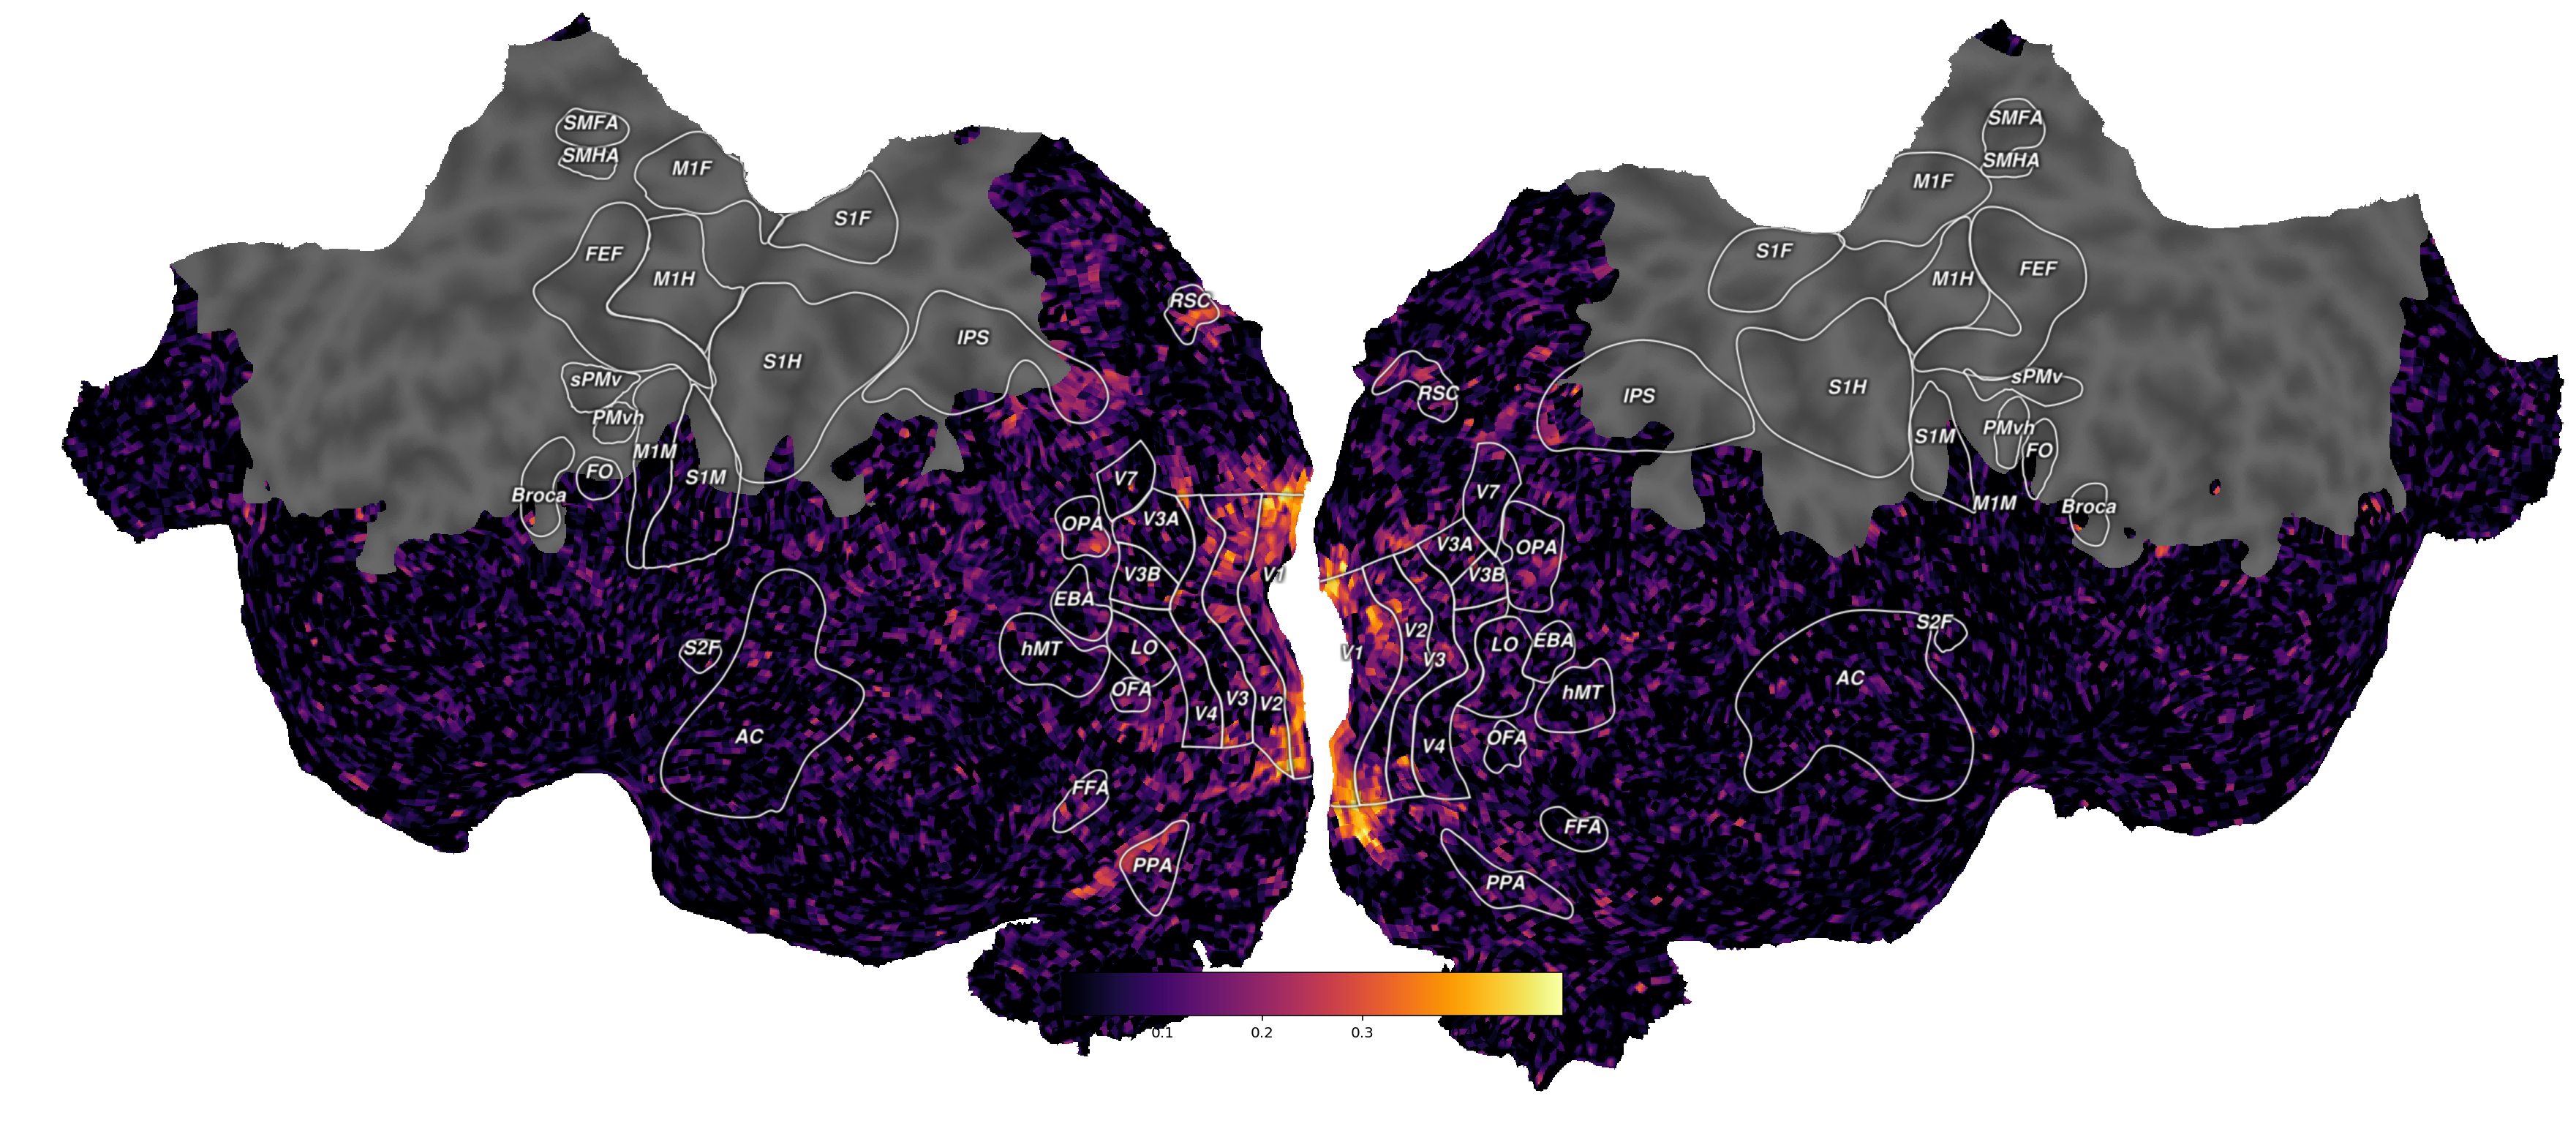

In [55]:
fig2 = cx.quickflat.make_figure(Vridge, with_curvature=True)

In [118]:
good_voxels = out['cc'] > 0.4

In [119]:
wts = out['weights'][:, good_voxels]

In [120]:
wts.shape

(256, 79)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


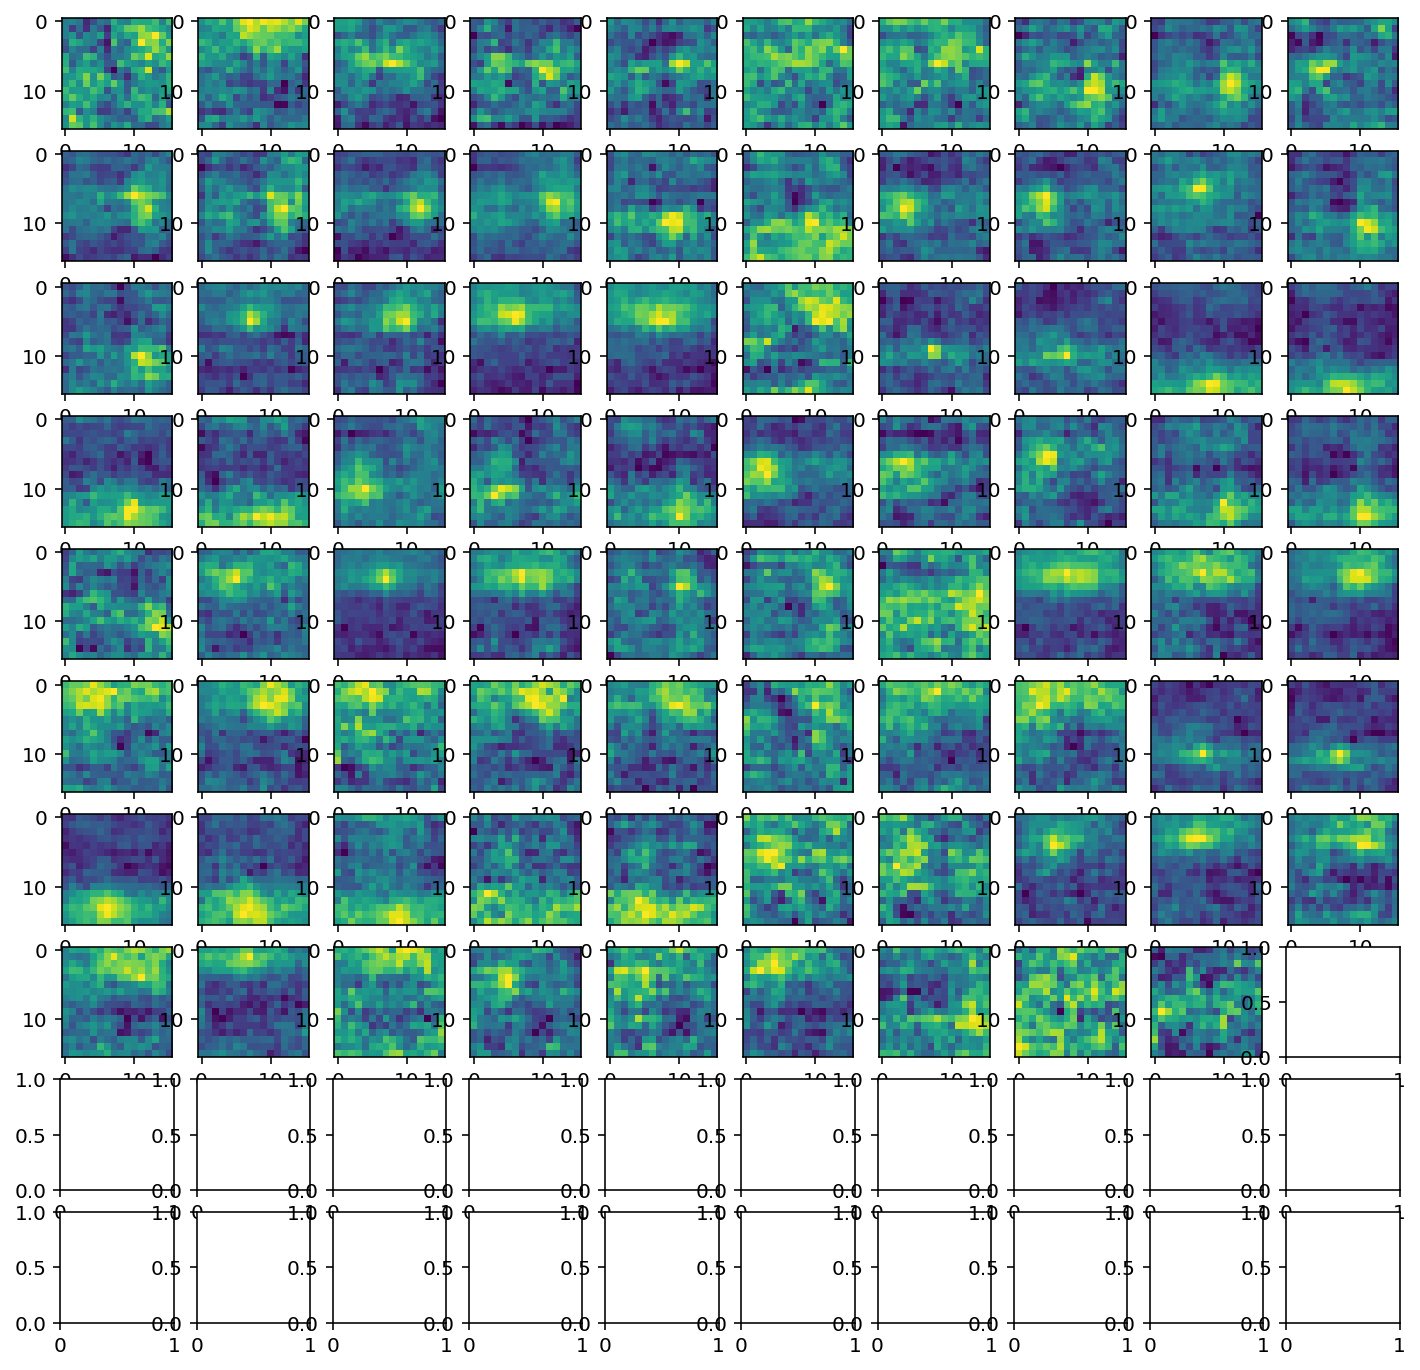

In [121]:
fig, axs = plt.subplots(10,10, figsize=(12, 12))
for i, ax in zip(range(0, 79), axs.flatten()):
    ax.imshow(wts[:,i].reshape(16,16))

Fit a mean and standard deviation for each set of weights.

In [122]:
def gauss2d(xy, mux=0, muy=0, sigma=1, amp=1):
    x, y = xy
    g = amp * np.e**(-((x-mux)**2 + (y-muy)**2)/(2*sigma**2))
    return g

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


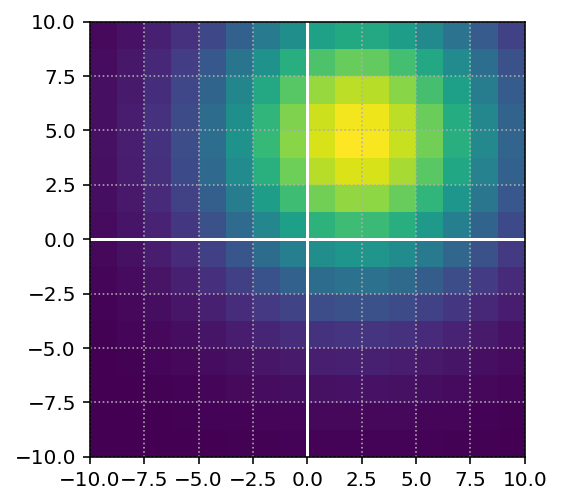

In [123]:
fig, ax = plt.subplots()
t = np.linspace(-10, 10, 16)
xg, yg = np.meshgrid(t, t)
ax.imshow(gauss2d((xg,yg), mux=2.5, muy=5, sigma=5), extent=[-10, 10, 10, -10])
ax.set_ylim([-10, 10])
ax.axhline(0, color='w')
ax.axvline(0, color='w')
ax.set_xticks(np.arange(-10, 11, 2.5))
ax.grid(axis='both', linestyle=':')

In [124]:
from scipy import optimize

In [125]:
wts[:, 0].shape

(256,)

In [136]:
i = 22
params_g, pcov = optimize.curve_fit(gauss2d, (xg.flatten(), yg.flatten()), wts[:,i], p0=[0, 0, 4, 1])

In [137]:
mux_, muy_, sigma_, amp_ = params_g

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


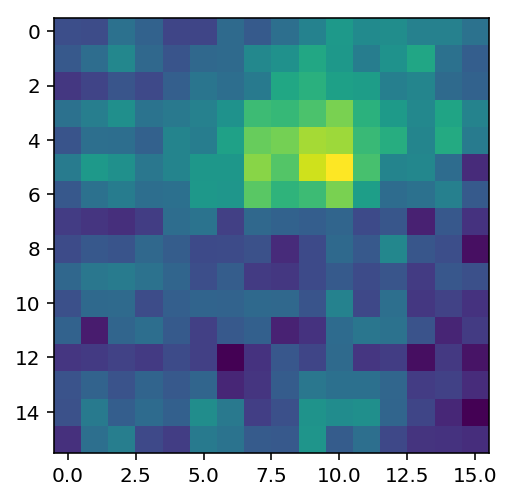

In [138]:
plt.imshow(wts[:,i].reshape(16,16))

In [139]:
sigma_

14.445142777622173

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


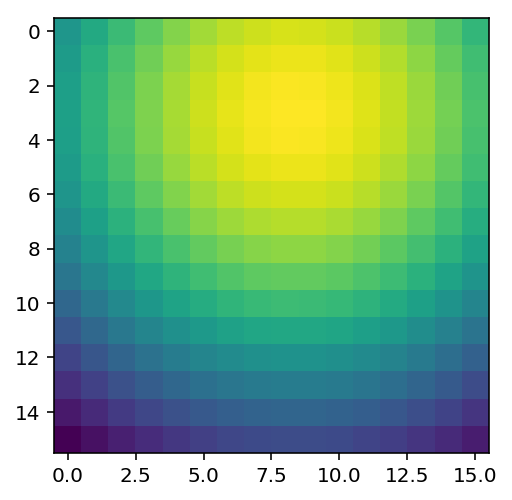

In [140]:
plt.imshow(gauss2d((xg, yg), mux=mux_, muy=muy_, sigma=sigma_))

In [141]:
wts.shape

(256, 79)

In [143]:
mu_xs = np.zeros((wts.shape[1],))
mu_ys = np.zeros((wts.shape[1],))
sigmas = np.zeros((wts.shape[1],))

for i, w in enumerate(wts.T):
    try:
        params_g, pcov = optimize.curve_fit(gauss2d, (xg.flatten(), yg.flatten()), w, p0=[0, 0, 1, 1])
        mux_, muy_, sigma_, amp_ = params_g
    except:
        mux_, muy_, sigma_ = np.nan, np.nan, np.nan
    mu_xs[i] = mux_
    mu_ys[i] = muy_
    sigmas[i] = sigma_

/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(-10, 10)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


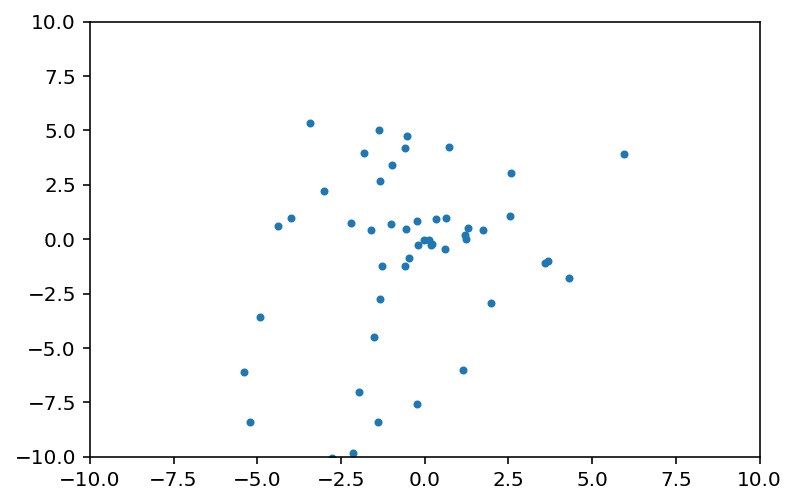

In [145]:
plt.plot(mu_xs,mu_ys, '.')
plt.xlim([-10, 10])
plt.ylim([-10, 10])